# Gender Classification

## Introduction
The aim of the article is to choose the best gender classification model between Logistic Regresson, SVM, Random Forest and Adaptive Boost algorithms. The particular thing about this is that we have relatively small data about famous public figures. We will also see how well the chosen model works for normal people like us. I suspect that the best model will be SVM, but let's see what happens.

## Table of content
- [Introduction](#Introduction)
- [Data processing](#Data-processing)
    - [How to get the image dataset?](#How-to-get-the-image-dataset?)
    - [Image data description](#Image-data-description)
    - [Reducing the examples and balancing the data](#Reducing-the-examples-and-balancing-the-data)
    - [Separating the data](#Separating-the-data)
- [Dimensionality reduction](#Dimensionality-reduction)
    - [Image transformations](#Image-transformations)
    - [Feature selection](#Feature-selection)
        - [Data normalization](#Data-normalization)
        - [Chose the best features](#Chose-the-best-features)
        - [Eigenfaces](#Eigenfaces)
- [Model selection](#Model-selection)
    - [Preparation](#Preparation)
        - [Import the dataset](#Import-the-dataset)
        - [Define an util functions](#Define-an-util-functions)
    - [Logistic Regression model](#Logistic-Regression-model)
        - [Basic Logistic Regression](#Basic-Logistic-Regression)
        - [Tune the Logistic Regression params](#Tune-the-Logistic-Regression-params)
        - [Analyse the results](#Analyse-the-results)
    - [Train SVM model](#Train-SVM-model)
        - [Basic Linear SVM model](#Basic-Linear-SVM-model)
        - [Tune the Linear SVM model](#Tune-the-Linear-SVM-model)
        - [Gaussian SVM model](#Gaussian-SVM-model)
        - [Select the best SVM Model](Select-the-best-SVM Model)    
    - [Random Forest clasifier](#Random-Forest-Clasifier)
        - [Basic Random Forest](#Basic-Random-Forest)
        - [Tune Random Forest parameters](#Tune-Random-Forest-parameters)
    - [Adaptive Boost](#Adaptive-Boost)
        - [Basic AdaBoost with Decision Tree](#Basic-AdaBoost-with-Decision-Tree)
        - [Tune the AdaBoost parameters](#Tune-the-AdaBoost-parameters)
    - [Experimental: attempt to combine models](#Experimental:-attempt-to-combine-models)  
    - [Best model selection](#Best-model-selection)
- [Demo](#Demo)

I recommend you to install the `opencv` through `pip` because there is well known issues with the `conda` distribution - especially for Linux. The `opencv` library is used for the feature extraction and the [demo](#Demo) because it is easy work with camera and haar faces.

In [1]:
#run: `!conda remove --yes opencv` to remove conda opencv
!pip install opencv-python

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [63]:
%matplotlib inline

import os
import urllib
import tarfile
import re
from shutil import copyfile
import random
import time
import itertools
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import urllib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Constants
NUMBER_OF_SAMPLES = 2900
RESIZE_SHAPE = (40, 40) # (64, 64)
FEMALE_CLASS = 0
MALE_CLASS = 1

In [17]:
np.random.seed(42)
random.seed(42)

## Data processing
### How to get the image dataset?
If you want to download end extract the image dataset you can run the cell bellow. It will automate the downloading and extracting the image data. Note that this is not very fact process. Alternatively you can download the image data from [here](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) and extract the `lfw-funneled.tar` file to `./faces_data/original_data/lfw-funneled` folder. On Windows for example you can use `7zip` extractor. Otherwise you can skip this part and downalod the generated `.csv` [later](#Feature-extraction).

In [3]:
# Time: ~5 minutes
# Downloads the  data
print("Downloading image data...")
response = urllib.request.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz")
tar_url = response[0]
print("Image data downalod location: '{}'".format(response))

Image data downalod location: '('/tmp/tmp8hhxx3b1', <http.client.HTTPMessage object at 0x7f7942c82278>)'


In [5]:
# Time: typically this is extremely fast process but can be very slow on Windows
# Extracts the downloaded data to './faces_data/original_data/lfw-funneled' directory
def extract(tar_url, extract_path="."):
    print("Source directory: '{}'".format(tar_url))
    print("Extracting to: '{}'".format(extract_path))
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])         
            
extract(tar_url, "./faces_data/original_data")
print('Done.')

Source directory: '/tmp/tmp8hhxx3b1'
Extracting to: './faces_data/original_data'
Done.


In [8]:
# This operation is not mandatory
# Removes the downlaoded *.tar file from the temporary folder
try:
    print("Removing '{}' ...".format(tar_url))
    os.remove(tar_url)
except Exception as ex:
    print(ex)
print('Done.')    

Removing '/tmp/tmp8hhxx3b1' ...
[Errno 2] No such file or directory: '/tmp/tmp8hhxx3b1'
Done.


## Image data description
We have datacet with `~5700` persons. Each person is assosiated with a folders with several pictires. The all pictures are `~13200`. The folders are not labeled but we have files with the female names and male names, so we can label each image easy. Each picture has dimensions `250x250px`. 
`./faces_data/original_data/female_names.txt`  
`./faces_data/original_data/male_names.txt`

Here we will defice some constant. We will use `2900` samples for the females and the same amount for the males. The base image size is `40x40` the lables are: `female -> 0` and `male -> 1`.

Let's make some calculations and data visualization by labels and plot them:

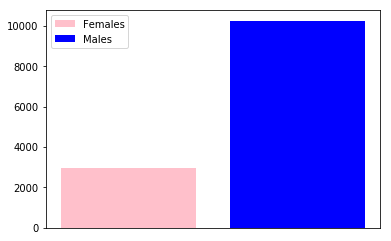

Females: 2966
Males: 10268


In [4]:
female_names_data = pd.read_csv('./faces_data/original_data/female_names.txt', header=None, sep='\n')
male_names_data = pd.read_csv('./faces_data/original_data/male_names.txt', header=None, sep='\n')

female_count = len(female_names_data)
male_count = len(male_names_data)

# plot diagram
fig, ax = plt.subplots()
colors = ['pink', 'blue']
rectangles = ax.bar((1, 2), (female_count, male_count), color=colors, width=0.8)
ax.xaxis.set_visible(False)
ax.legend((rectangles[0], rectangles[1]), ('Females', 'Males'))
plt.show()

print("Females: {}".format(female_count))
print("Males: {}".format(male_count))

From the graph we can see that we have high unbalanced data. Furthermore we have we have a relatively large number of exmples and a huge number number of features `250*250=62500` and each feature has 3 component because the picture is colorful. With the components the features are `187500`! For this reason, I will make some suggestions and simplifications so that I can train my machine learning model on my processor for some tolerable period of time:
- I can get rid of the unbalanced data and the large number of examples by making the women/men ratio ~50/50
- I can reduce the huge number of features by making grayscale image and apply some image transformations. 
- In addition later I can use a feature extraction algorithm to reduce the number of features.
- I can perform data normalization because some algorihms works better with normalized data

So there is something to be done. Let's get to work!

### Reducing the examples and balancing the data
We have more men than women, so we can take all women and we can randomly get the same number of men:

In [6]:
female_names = female_names_data.get_values()[0:, 0]
male_names = male_names_data.get_values()[0:, 0]

female_names = random.sample(set(female_names), NUMBER_OF_SAMPLES)
male_names = random.sample(set(male_names), NUMBER_OF_SAMPLES)

print("Females: {}".format(len(female_names)))
print("Males: {}".format(len(male_names)))

Females: 2900
Males: 2900


In [16]:
# test randomization
female_names1 = random.sample(set(female_names), NUMBER_OF_SAMPLES)
female_names2 = random.sample(set(female_names), NUMBER_OF_SAMPLES)

print(len(set(female_names1) & set(female_names2)) == 2900)

True


### Separating the data
Let's create two folders where we will hold the representatives of the relevant classes:

In [84]:
source_image_dir = "./faces_data/original_data/lfw_funneled/"
directory_female = "./faces_data/new_data/female/"
directory_male = "./faces_data/new_data/male/"
if not os.path.exists(directory_female):
    os.makedirs(directory_female)
if not os.path.exists(directory_male):
    os.makedirs(directory_male)

In [85]:
def separate_data(face_names_data, source, destination):
    for image_name in face_names_data:
        name = re.match("([A-Za-z_-]+)_(\d+.jpg)", image_name)
        if name is None:
            print("Name: {}".format(image_name))
        name = name.group(1)    
        path = source_image_dir + name + "/" + image_name
#         if os.path.exists:
#             print(path)
        #print(path)
        copyfile(path, destination + image_name)

In [86]:
# separates the data
separate_data(female_names, source_image_dir, directory_female)
separate_data(male_names, source_image_dir, directory_male)

In [87]:
# test print for the selected names
female_image_names = os.listdir("./faces_data/new_data/female")
male_image_names = os.listdir("./faces_data/new_data/male")
print(len(female_image_names))
print(len(male_image_names))

2900
2900


## Dimensionality reduction

### Image transformations

Now I'll extract the features from the image following this actions:
1. Get the original image
2. Convet the image to garyscale
3. Define the region of interests. Use haar faces to detect a face (if exist) on the image. If there is more than one faces, I'll get the square with the larger area.
4. Crop the square from the gray image
5. Apply gaussian kernel over the cripped image to reduce the noise.
6. Resize the image to 40x40px  

| | | |
|: - :|: - :|: - :|
|![original image](./markdown_res/Amelia_Vega_0001.jpg) | ![gray image](./markdown_res/Amelia_Vega_0001_gray.bmp) | ![face](./markdown_res/Amelia_Vega_0001_face.bmp) |
| ![cropped face](./markdown_res/Amelia_Vega_0001_cropped.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_kernel.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_resized.bmp) |

In [88]:
gender_faces_data = None
gender_faces_data = np.empty(shape=(0,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]+1)) #64*64+1
face_cascade = cv2.CascadeClassifier('./faces_data/face.xml')

def extract_features(image_path, label):
    """ Extracts features from a image
    :param image_path: the path to the image
    :param label: the label of the image
    :return: extracted features from the image with the corresponding label as a row matrix
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    row = None
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is not ():
        face = sorted(faces, key=lambda x: (x[2] * x[3]), reverse=True)[0]
        x, y, width, height = face
        face_gray = gray[y: y + height, x: x + width]
        
        # apply Gaussian kernel
        kernel = np.ones((3,3),np.float32)/9
        face_gray = cv2.filter2D(face_gray,-1,kernel)
        
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        row = np.append(resized.ravel(), label)

    return row

def append_data(prefix_path, label, gender_faces_data):
    image_names = os.listdir(prefix_path)
    for image_path in image_names:
        # print(image_path)
        curr_row = extract_features(prefix_path + image_path, label)
        if curr_row is not None:
            gender_faces_data = np.append(gender_faces_data, [curr_row], axis=0)
        
    return gender_faces_data  

In [89]:
# Append the female faces
gender_faces_data = append_data('./faces_data/new_data/female/', FEMALE_CLASS, gender_faces_data)
female_data_shape = gender_faces_data.shape

# Append the male faces
gender_faces_data = append_data('./faces_data/new_data/male/', MALE_CLASS, gender_faces_data)
male_data_shape = gender_faces_data.shape

print("Female data shape: {}".format(female_data_shape))
print("Male data shape: {}".format(male_data_shape))

(2737, 1601)
(5487, 1601)


In [90]:
# Suffle the data
np.random.shuffle(gender_faces_data)
gender_faces_data

array([[ 40.,  32.,  26., ...,  87.,  86.,   1.],
       [ 59.,  56.,  49., ...,  72.,  84.,   0.],
       [ 29.,   6.,  13., ..., 105., 200.,   0.],
       ...,
       [ 38.,  56.,  68., ...,  29.,  34.,   1.],
       [ 12.,  15.,  17., ...,  12.,  11.,   1.],
       [188., 188., 188., ..., 108., 173.,   1.]])

Now the data for the model is generated. The only thing left is to keep it in a file:

In [91]:
np.savetxt("./faces_data/genders_data_40x40_large_2.csv", gender_faces_data.astype(np.int), delimiter=",")

### Feature extraction

In [5]:
dataset_file = "./faces_data/genders_data_40x40_large_2.csv"
if not os.path.exists(dataset_file):
    # Downloads the  data
    print("Downloading a dataset...")
    response = urllib.request.urlretrieve(
        "https://www.dropbox.com/s/5rp97ixw8a85v1t/genders_data_40x40_large_2.csv?dl=1", dataset_file)
    print("Dataset downalod location: '{}'".format(response[0]))

gender_faces_data = pd.read_csv(dataset_file, sep=',', header=None)
gender_faces_data.head()

Dataset downalod location: './faces_data/genders_data_40x40_large_2.csv'


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,40.0,32.0,26.0,23.0,21.0,22.0,29.0,67.0,84.0,67.0,...,106.0,93.0,93.0,94.0,92.0,92.0,90.0,87.0,86.0,1.0
1,59.0,56.0,49.0,40.0,40.0,46.0,61.0,80.0,109.0,119.0,...,196.0,173.0,178.0,200.0,192.0,162.0,60.0,72.0,84.0,0.0
2,29.0,6.0,13.0,26.0,9.0,4.0,5.0,30.0,62.0,106.0,...,87.0,17.0,22.0,57.0,68.0,65.0,55.0,105.0,200.0,0.0
3,79.0,83.0,86.0,86.0,87.0,86.0,81.0,64.0,29.0,70.0,...,67.0,93.0,100.0,108.0,119.0,133.0,134.0,131.0,161.0,1.0
4,29.0,28.0,32.0,53.0,75.0,66.0,60.0,70.0,71.0,70.0,...,143.0,82.0,12.0,24.0,34.0,43.0,45.0,40.0,34.0,1.0


#### Data normalization
It is better to normalize the data before trying diffrent feature selection algorihms

In [6]:
# get features
features = gender_faces_data.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

# get labels
labels = gender_faces_data.as_matrix()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(5487, 1600)
(5487,)
[1. 0. 0. ... 1. 1. 1.]


In [95]:
# calculates the final counts
unique, count = np.unique(labels, return_counts=True)
print("Females count: {}".format(count[0]))
print("Males count: {}".format(count[1]))
# out = np.histogram(labels, bins=labels)
print(dict(zip(unique, count)))

Females count: 2737
Males count: 2750
{0.0: 2737, 1.0: 2750}


#### Chose the best features
It is dificult to find the best `PCA` parameters but I can make very rough approximations with something like grid search.

In [97]:
print("Features shape: {}".format(features.shape))
features_counts = [80, 140, 200, 260, 320, 380, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {} ...".format(f_count))
    pca = PCA(n_components=f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        reduced_features, labels, train_size=0.7, test_size=0.3, random_state=0)
    
    logistic_regression = LogisticRegression(C=0.001)
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print("    train_score: {}".format(train_score))
    print("    test_score: {}".format(test_score))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
print("Finished.")

Features shape: (5487, 1600)
Reducing features to 80 ...
    train_score: 0.8390625
    test_score: 0.8318154219793564
Reducing features to 140 ...
    train_score: 0.8572916666666667
    test_score: 0.840922890103218
Reducing features to 200 ...
    train_score: 0.8559895833333333
    test_score: 0.8421372191863995
Reducing features to 260 ...
    train_score: 0.8580729166666666
    test_score: 0.8397085610200364
Reducing features to 320 ...
    train_score: 0.8598958333333333
    test_score: 0.8397085610200364
Reducing features to 380 ...
    train_score: 0.8598958333333333
    test_score: 0.8427443837279903
Reducing features to 440 ...
    train_score: 0.8614583333333333
    test_score: 0.8421372191863995
Reducing features to 1000 ...
    train_score: 0.8630208333333333
    test_score: 0.8421372191863995
Finished.


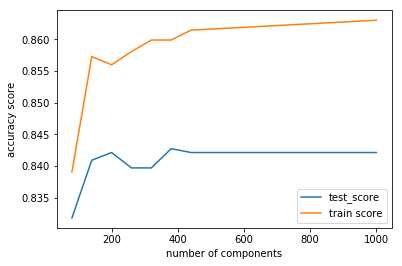

In [98]:
plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)
plt.legend(["test_score", "train score"])
plt.xlabel("number of components")
plt.ylabel("accuracy score")
plt.show()

I know that this type of calculation can be misleading because I have not applied cross validation and grid rearch for the best parameters. However, they may be a very general reference and correspond to what I have identified with many attempts. So `n_components=200` is a good choice.

#### Eigenfaces
Let's see what the computer actually sees:

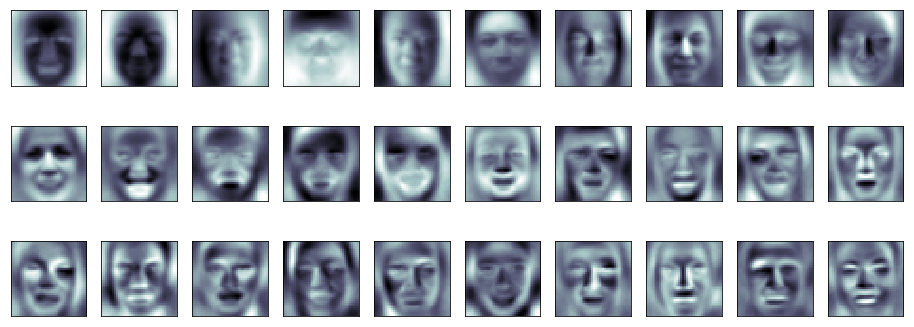

In [655]:
eigenface_scaler = StandardScaler()
eigenface_features = scaler.fit_transform(features)

fig = plt.figure(figsize=(16, 6))
pca_eigenface = PCA(n_components=200, whiten=True)
pca_eigenface.fit(eigenface_features)

for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    plt.imshow(pca_eigenface.components_[i].reshape((40,40)), cmap=plt.cm.bone)

## Model selection

### Preparation

#### Import the dataset

In [66]:
gender_faces_data = pd.read_csv('./faces_data/genders_data_40x40_large_2.csv', sep=',', header=None)

print(gender_faces_data.shape)
gender_faces_data.head()

(5487, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,40.0,32.0,26.0,23.0,21.0,22.0,29.0,67.0,84.0,67.0,...,106.0,93.0,93.0,94.0,92.0,92.0,90.0,87.0,86.0,1.0
1,59.0,56.0,49.0,40.0,40.0,46.0,61.0,80.0,109.0,119.0,...,196.0,173.0,178.0,200.0,192.0,162.0,60.0,72.0,84.0,0.0
2,29.0,6.0,13.0,26.0,9.0,4.0,5.0,30.0,62.0,106.0,...,87.0,17.0,22.0,57.0,68.0,65.0,55.0,105.0,200.0,0.0
3,79.0,83.0,86.0,86.0,87.0,86.0,81.0,64.0,29.0,70.0,...,67.0,93.0,100.0,108.0,119.0,133.0,134.0,131.0,161.0,1.0
4,29.0,28.0,32.0,53.0,75.0,66.0,60.0,70.0,71.0,70.0,...,143.0,82.0,12.0,24.0,34.0,43.0,45.0,40.0,34.0,1.0


In [67]:
features = gender_faces_data.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]] #features = gender_faces_data[:, :50*50] # features = gender_faces_data.as_matrix()[:, :50*50]
print(features.shape)

(5487, 1600)


In [68]:
labels = gender_faces_data.as_matrix()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(5487,)
[1. 0. 0. ... 1. 1. 1.]


#### Define an util functions

In [69]:
def plot_roc_curve(estimator, features_test, labels_test, title):
    """ Plots ROC curve"""
    logit_roc_auc = roc_auc_score(labels_test, estimator.predict(features_test))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        labels_test, estimator.predict_proba(features_test)[:,1])
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='{} (area = {:0.2f})'.format(title, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    return plt

In [70]:
def print_grid_search_results(grid_search_pipeline, splits):
    """ Prints reformated version of the cv_results_
    :param grid_search_pipeline: grid_search estimator
    :param splits: the number of the kFold splits
    :return: table with parameters
    """
    results = pd.DataFrame(grid_search_pipeline.cv_results_)
    results = results.drop(['mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time', 'params'], axis=1)
    columns = columns={"param_pca__n_components": "param_pca", "param_classifier__C": "param_C", 
                       "mean_test_score": "mean_test","mean_train_score": "mean_train", "rank_test_score": 
                       "rank_test", "param_clf__n_estimators": "n_estimators"}
    for i in range(0, splits):
        columns["split" + str(i) + "_train_score"]="split" + str(i) + "_train"
        columns["split" + str(i) + "_test_score"]="split" + str(i) + "_test"
    results = results.rename(columns=columns)
    results.sort_values(by='rank_test', inplace=True)
    return results.head(len(grid_search_pipeline.cv_results_['params']))

In [71]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    For more info see the origanl documtation here: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic Regression model

#### Basic Logistic Regression
I will create a `pipeline` for the models because it is convenient to use not only during training but also during the use of the model. I can simply call `pipeline_model.predict(...)` and it will handle the `PCA` and `Scaler` transformations for the input data. It is therefore a prerequisite for fewer mistakes. On the other hand, invoking `PCA` and `Scaler` every time when creating each model will reduce performance. But for the purposes of this study, this is not so important.

In [73]:
# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=42)

In [74]:
# creates a pipeline for Logistic Regression
logistic_regression_pipe = None
logistic_regression = LogisticRegression(random_state=42)
logistic_regression_pipe = Pipeline(steps=[('scaler_before', StandardScaler()), 
                          ('pca', PCA(n_components=150)),
                          ('scaler_after', StandardScaler()),
                          ('classifier', logistic_regression)])

In [75]:
# fit the basic Logistic Regression model
logistic_regression_pipe.fit(features_train, labels_train)

Pipeline(memory=None,
     steps=[('scaler_before', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler_after', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifie...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [76]:
print("Basic logistic regression test accuracy score: {}".format(
    logistic_regression_pipe.score(features_test, labels_test)))
print("Basic logistic regression train accuracy score: {}".format(
    logistic_regression_pipe.score(features_train, labels_train)))
print("Basic logistic regression F1 score: {}".format(
    f1_score(labels_test, logistic_regression_pipe.predict(features_test))))
# Basic logistic regression test accuracy score: 0.8439587128111719
# Basic logistic regression train accuracy score: 0.8669270833333333
# Basic logistic regression F1 score: 0.8458308338332333

Basic logistic regression test accuracy score: 0.8439587128111719
Basic logistic regression train accuracy score: 0.8651041666666667
Basic logistic regression F1 score: 0.8456456456456457


The result seems fairly good but we need to check whether this is due to the separation of data (see the difference between the train score and the test score). Moreover we also need to look for better parameters. So we have to make `kFold cross validation` and `grid search`.

#### Tune the Logistic Regression params

In [77]:
# Time: ~1 min
# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

params = dict(classifier__C=[0.0001, 0.001, 0.01, 1], # [0.0001, 0.001, 0.01, 1]
              #classifier__penalty=['l1', 'l2'],
              pca__n_components=[150, 200])

# init kFold validation
kfold = StratifiedKFold(n_splits=8)

# Grid search for the best Logistic Regression parameters
grid_search_logistic_regresion = GridSearchCV(
    logistic_regression_pipe, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)

grid_search_logistic_regresion.fit(features_train, labels_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler_before', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler_after', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifie...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'classifier__C': [0.0001, 0.001, 0.01, 1], 'pca__n_components': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
grid_search_logistic_regresion.best_params_
# {'classifier__C': 0.01, 'pca__n_components': 150}

{'classifier__C': 0.001, 'pca__n_components': 150}

In [79]:
print("Logistic Regression Grid Search best score: {}".format(grid_search_logistic_regresion.best_score_))
# Logistic Regression Grid Search best score: 0.8486979166666667

Logistic Regression Grid Search best score: 0.8479166666666667


In [80]:
print_grid_search_results(grid_search_logistic_regresion, splits=8)
# grid_search_logistic_regresion.param_grid
# grid_search_logistic_regresion.cv_results_

,mean_test,mean_train,param_C,param_pca,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,...,split4_test,split4_train,split5_test,split5_train,split6_test,split6_train,split7_test,split7_train,std_test_score,std_train_score
2,0.847917,0.866071,0.001,150,1,0.856549,0.864841,0.829167,0.864286,0.837500,...,0.858333,0.863988,0.829167,0.873512,0.864583,0.864286,0.851775,0.866409,0.013023,0.003242
0,0.846875,0.865848,0.0001,150,2,0.846154,0.864543,0.831250,0.860714,0.829167,...,0.864583,0.865476,0.831250,0.866667,0.858333,0.862798,0.853862,0.870277,0.013599,0.002925
1,0.846875,0.869903,0.0001,200,2,0.848233,0.869902,0.843750,0.869345,0.827083,...,0.847917,0.871726,0.833333,0.868452,0.858333,0.870833,0.849687,0.871169,0.011825,0.002703
6,0.845573,0.867187,1,150,4,0.852391,0.867222,0.816667,0.862500,0.831250,...,0.858333,0.864881,0.835417,0.866667,0.862500,0.868155,0.849687,0.869979,0.015081,0.002367
4,0.845313,0.868527,0.01,150,5,0.850312,0.866627,0.827083,0.863690,0.833333,...,0.856250,0.869345,0.829167,0.870238,0.862500,0.866071,0.843424,0.869979,0.013268,0.002820
7,0.844271,0.872544,1,200,6,0.862786,0.869604,0.845833,0.871429,0.835417,...,0.845833,0.875595,0.827083,0.875893,0.852083,0.871429,0.841336,0.876227,0.009951,0.003259
5,0.843490,0.872210,0.01,200,7,0.846154,0.869902,0.841667,0.871131,0.827083,...,0.839583,0.877976,0.822917,0.873214,0.856250,0.873512,0.851775,0.870872,0.012801,0.002605
3,0.842969,0.870759,0.001,200,8,0.844075,0.868413,0.852083,0.870238,0.818750,...,0.852083,0.873810,0.820833,0.872917,0.850000,0.872024,0.847599,0.866409,0.013923,0.002619


#### Analyse the Logistic Regression results
Let's plot some graphs. This would help us to estimate what our algorithm suffers in a more intuitive way.
##### Learning curve
The `Learning curve` would help us figure out if our algorithm suffers from a **high bias** or **high variance**

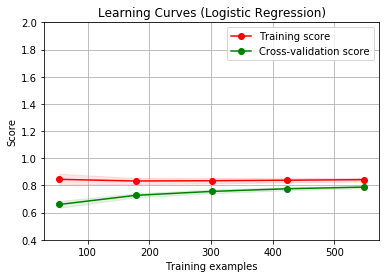

In [81]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.9, random_state=0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA(n_components=150)
pca_features = pca.fit_transform(scaled_features)

estimator = LogisticRegression(C=0.001)
#estimator.fit(features_test, labels_test)
plot_learning_curve(estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
# print(plt.rcParams["figure.figsize"])
# plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

It can be seen from the figure above that with appropriate regulation and an increase in the number of samples, we can reduce the **varince** between test data and train data significantly but we can not achieve a score greater than `0.85`. This means that in order to achieve better results we may increase the **bias**.

##### Confusion matrix

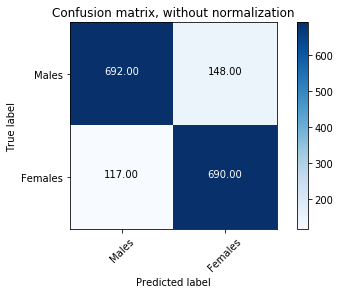

In [19]:
cnf_matrix = confusion_matrix(labels_test, grid_search_logistic_regresion.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), 
                      title='Confusion matrix, without normalization', normalize=True)
# plt.rcParams["figure.figsize"] = (8, 5)
plt.show()

The matrix shows that our classifier tends to classify some men as women more than vice versa (Nowadays, there are no real men...). Maybe the content of more images with men on the original set is not accidental. It is possible to deal with this problem if we take more males's samples from the original data.

##### ROC Curve

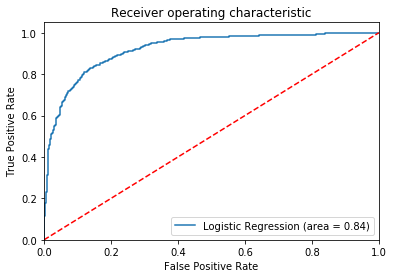

In [20]:
estimator = grid_search_logistic_regresion.best_estimator_
roc = plot_roc_curve(estimator, features_test, labels_test, title="Logistic Regression")
roc.show()

### Train SVM model

#### Basic Linear SVM model

In [82]:
np.random.rand(12345)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [83]:
linear_svm = LinearSVC(random_state=42)
linear_svm_pipeline = Pipeline(steps=[('scl', StandardScaler()), 
                               ('pca', PCA(n_components=200, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', linear_svm)])

linear_svm_pipeline.fit(features_train, labels_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('scl_2', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))])

In [84]:
print("Train score: {}".format(linear_svm_pipeline.score(features_train, labels_train)))
print("Test score: {}".format(linear_svm_pipeline.score(features_test, labels_test)))
print("Diff score: {}".format(
    linear_svm_pipeline.score(features_train, labels_train) - linear_svm_pipeline.score(features_test, labels_test)))
# Train score: 0.8671875
# Test score: 0.8457802064359441
# Diff score: 0.021407293564055907

Train score: 0.87109375
Test score: 0.8427443837279903
Diff score: 0.02834936627200968


The difference between the train score and test score is relatively high and the train score is very high. That means high variance and/or imbalanced data between the training set and the test set. So we need to perform k-Fold coross validation with stratification and grid search to to evaluate the variance and the best parameters for this algorithm with the concrete amount of training data.

#### Tune the Linear SVM model

In [85]:
# unique, count = np.unique(labels_train, return_counts=True)
# print("Females count: {}".format(count[0]))
# print("Males count: {}".format(count[1]))
# # out = np.histogram(labels, bins=labels)
# print(dict(zip(unique, count)))

In [86]:
# Time: ~1 min
linear_svm_params = dict(clf__C = [0.0001, 0.001, 1], pca__n_components=[150, 200]) # clf__C =0.00001, 0.0001, 0.001, clf__dual = [True, False]
kfold = StratifiedKFold(n_splits=7)
grid_search_linear_svm = GridSearchCV(
    linear_svm_pipeline, param_grid=linear_svm_params, cv=kfold, return_train_score=True)

start = time.time()
grid_search_linear_svm.fit(features_train, labels_train)
end = time.time()

In [87]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_linear_svm.cv_results_['params'])))

GridSearchCV took {67.71} seconds for 6 candidate parameter settings.


In [88]:
grid_search_linear_svm.best_params_ # {'clf__C': 1, 'pca__n_components': 150}

{'clf__C': 1, 'pca__n_components': 150}

In [89]:
grid_search_linear_svm.best_score_ # 0.8463541666666666

0.84921875

In [90]:
grid_search_linear_svm.best_estimator_.score(features_test, labels_test) # 0.8451730418943534

0.8445658773527626

In [91]:
grid_search_linear_svm.best_estimator_.score(features_train, labels_train) # 0.8671875

0.8658854166666666

In [92]:
# grid_search_linear_svm.cv_results_
# print(classification_report(labels_test, grid_search_linear_svm.predict(features_test)))
print_grid_search_results(grid_search_linear_svm, splits=8)

,mean_test,mean_train,param_clf__C,param_pca,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,...,split3_test,split3_train,split4_test,split4_train,split5_test,split5_train,split6_test,split6_train,std_test_score,std_train_score
4,0.849219,0.868620,1,150,1,0.845173,0.871771,0.846995,0.865998,0.832423,...,0.852459,0.869341,0.850365,0.870292,0.863139,0.861786,0.854015,0.871203,0.008718,0.003279
5,0.848698,0.872786,1,200,2,0.856102,0.872075,0.865209,0.871468,0.828780,...,0.854281,0.869644,0.841241,0.876063,0.850365,0.871507,0.844891,0.876367,0.010881,0.002314
3,0.846094,0.871658,0.001,200,3,0.837887,0.871468,0.863388,0.867821,0.834244,...,0.865209,0.870556,0.835766,0.874848,0.844891,0.870595,0.841241,0.872722,0.011979,0.002143
2,0.845833,0.868012,0.001,150,4,0.841530,0.869948,0.846995,0.862656,0.830601,...,0.841530,0.865998,0.844891,0.873329,0.859489,0.861482,0.855839,0.872114,0.008927,0.004321
0,0.845313,0.866840,0.0001,150,5,0.850638,0.867214,0.832423,0.862960,0.826958,...,0.846995,0.863567,0.848540,0.871810,0.854015,0.861786,0.857664,0.869380,0.010509,0.003804
1,0.844792,0.870529,0.0001,200,6,0.841530,0.868429,0.856102,0.867517,0.828780,...,0.861566,0.867517,0.841241,0.874848,0.841241,0.871810,0.843066,0.869684,0.010036,0.002801


#### Gaussian SVM model

In [93]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

svm_pipeline = Pipeline(steps=[('scl_1', StandardScaler()), 
                               ('pca', PCA(n_components=150, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', SVC(probability=True))])

svm_pipeline.fit(features_train, labels_train)

print(svm_pipeline.score(features_test, labels_test)) # 0.8755312689738919
print(svm_pipeline.score(features_train, labels_train)) # 0.9786458333333333

0.8755312689738919
0.9786458333333333


#### Tune the Gaussian SVM model parameters

The default `gamma` value works wll, so we will try some close values.

In [94]:
1./150

0.006666666666666667

In [95]:
# Time: ~3-3.5 min
kfold = StratifiedKFold(n_splits=5)
svm_params = dict(clf__C = [0.75, 1], clf__gamma=[0.007, 0.0075])

grid_search_svm = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_svm.fit(features_train, labels_train)
end = time.time()

In [96]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_svm.cv_results_['params'])))

GridSearchCV took {230.72} seconds for 4 candidate parameter settings.


In [36]:
grid_search_svm.best_params_ # {'clf__C': 1, 'clf__gamma': 0.007}

{'clf__C': 1, 'clf__gamma': 0.007}

In [37]:
grid_search_svm.best_estimator_.score(features_test, labels_test) # 0.8761384335154827

0.8761384335154827

#### Analyse the SVM results

##### ROC curve for Gaussian SVM

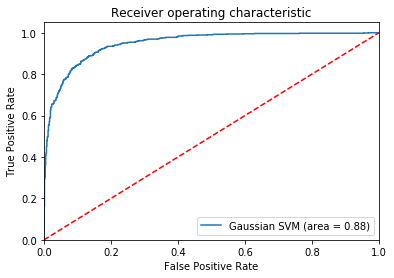

In [38]:
svm_estimator = grid_search_svm.best_estimator_
roc = plot_roc_curve(svm_estimator, features_test, labels_test, title="Gaussian SVM")
roc.show()

##### Learning curve for the Gaussian SVM

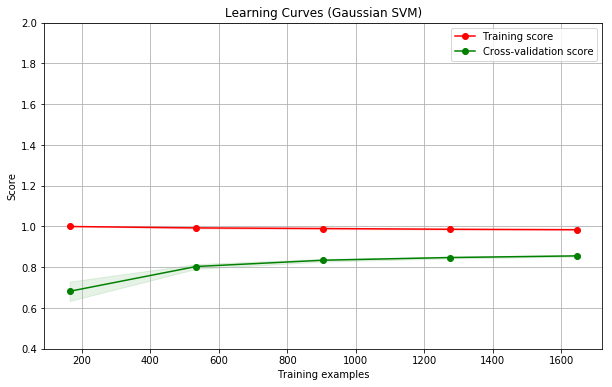

In [44]:
# Time: ~1 min
title = "Learning Curves (Gaussian SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)

plot_learning_curve(grid_search_svm.best_estimator_, title, features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
# print(plt.rcParams["figure.figsize"])
# plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

##### Confusion matrix for the Gaussian SVM

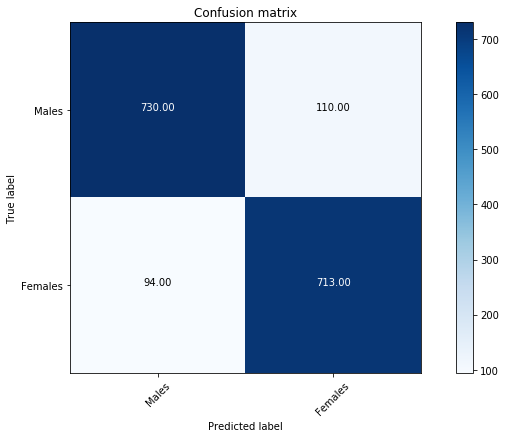

In [45]:
cnf_matrix = confusion_matrix(labels_test, grid_search_svm.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix', normalize=True)
plt.show()

### Random Forest Clasifier

#### Basic Random Forest

In [97]:
np.random.seed(123456)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [98]:
forest_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', RandomForestClassifier(criterion='gini'))])

forest_pipeline.fit(features_train, labels_train)

print(forest_pipeline.score(features_test, labels_test)) # 0.7698846387370978
print(forest_pipeline.score(features_train, labels_train)) # 0.8197916666666667

0.6727383120825744
0.9877604166666667


#### Tune Random Forest parameters

In [99]:
# Time: ~1 min
kfold = StratifiedKFold(n_splits=3)
forest_params = dict(clf__n_estimators = [1500, 2000], clf__max_depth=[2, 3])

grid_search_forest = GridSearchCV(
    forest_pipeline, param_grid=forest_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_forest.fit(features_train, labels_train)
end = time.time()

In [94]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_forest.cv_results_['params'])))

GridSearchCV took {63.03} seconds for 4 candidate parameter settings.


In [95]:
grid_search_forest.best_params_ # {'clf__max_depth': 3, 'clf__n_estimators': 1500}

{'clf__max_depth': 3, 'clf__n_estimators': 1500}

In [96]:
print(grid_search_forest.best_estimator_.score(features_test, labels_test)) # 0.7741347905282332
print(grid_search_forest.best_estimator_.score(features_train, labels_train)) # 0.81953125

0.7704918032786885
0.8111979166666666


In [97]:
print_grid_search_results(grid_search_forest, splits=3)

,mean_test,mean_train,param_clf__max_depth,n_estimators,rank_test,split0_test,split0_train,split1_test,split1_train,split2_test,split2_train,std_test_score,std_train_score
0,0.755469,0.803127,2,1500,3,0.750976,0.808128,0.782813,0.811719,0.732604,0.789535,0.020739,0.009722
1,0.755469,0.802085,2,2000,3,0.749415,0.802267,0.782031,0.813281,0.734949,0.790707,0.019689,0.009217
2,0.769531,0.844273,3,1500,1,0.768931,0.852677,0.792969,0.846875,0.746677,0.833268,0.018900,0.008134
3,0.769010,0.847007,3,2000,2,0.770492,0.853458,0.789844,0.848828,0.746677,0.838735,0.017650,0.006147


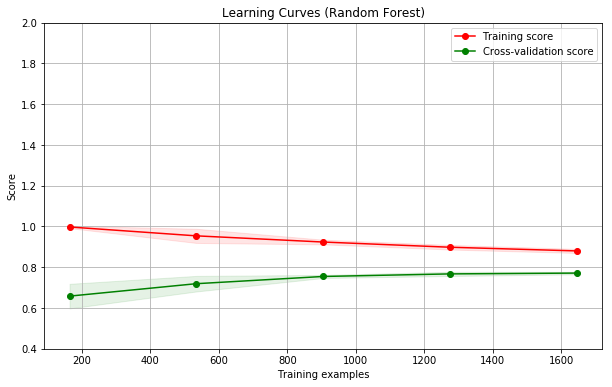

In [99]:
# Time: ~1.5 min
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)
plot_learning_curve(grid_search_forest.best_estimator_, 
                    "Learning Curves (Random Forest)", 
                    features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)
plt.show()

TODO: Write comments here

### Adaptive Boost

#### Basic AdaBoost with Decision Tree

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345) # , random_state=12345
# pca_components = 100
# tree_pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                                   ('pca', PCA(n_components=pca_components)),
#                                   #('scaler_1', StandardScaler()),
#                                   ('clf', DecisionTreeClassifier(max_depth=1))])
# #tree = DecisionTreeClassifier(max_depth=1)
# tree_pipe.fit(features_train, labels_train)

#SVC(kernel='linear', degree=1, probability=True) # DecisionTreeClassifier(max_depth=1)
# tree_pipe = DecisionTreeClassifier(n_estimators)
tree = DecisionTreeClassifier(max_depth=1)
# tree_pipe.fit(features_train, labels_train)
# print(tree_pipe.score(features_test, labels_test))

ada_boost_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', AdaBoostClassifier(tree))]) # 250 0.5 -tree
                                   # , n_estimators=150,learning_rate=0.35

ada_boost_pipeline.fit(features_train, labels_train)
print(ada_boost_pipeline.score(features_test, labels_test)) # 0.7644201578627808
print(ada_boost_pipeline.score(features_train, labels_train)) # 8169270833333333

0.7632058287795993
0.81953125


In [18]:
# Time: ~30 sec
ada_boost = AdaBoostClassifier(tree, n_estimators=100,learning_rate=0.5, random_state=42)
ada_boost.fit(features_train, labels_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=42)

In [19]:
ada_boost.score(features_test, labels_test) # 0.8020643594414086

0.8044930176077717

In [20]:
ada_boost.score(features_train, labels_train) # 0.865625

0.8697916666666666

#### Tune the AdaBoost parameters
Тhis is a very time consuming operation.

In [21]:
# Time: ~3-4 min
start = time.time()
params = {'n_estimators':[100, 150], 'learning_rate':[0.1, 0.35, 0.5] } # add 50
kfold = StratifiedKFold(n_splits=3)

ada_boost_grid_search = GridSearchCV(ada_boost, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)
ada_boost_grid_search.fit(features_train, labels_train)

end = time.time()
print(end - start)
ada_boost_grid_search

267.1334717273712


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=42),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100, 150], 'learning_rate': [0.1, 0.35, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
print("Best params: {}".format(ada_boost_grid_search.best_params_))
print("Test score: {}".format(ada_boost_grid_search.best_estimator_.score(features_test, labels_test))) 
# 0.8032786885245902
print("Train score: {}".format(ada_boost_grid_search.best_estimator_.score(features_train, labels_train))) 
# 0.88203125
print_grid_search_results(ada_boost_grid_search, splits=3)
# Best params: {'learning_rate': 0.35, 'n_estimators': 150}

Best params: {'learning_rate': 0.35, 'n_estimators': 150}
Test score: 0.8105646630236795
Train score: 0.8729166666666667


NameError: name 'print_grid_search_results' is not defined

### Experimental: attempt to combine models

In [395]:
new_features = [np.array([0, 0, 0])]
for image in features:
    svm = svm_result = grid_search_svm.predict_proba([image])[0][1]
    logr = grid_search_logistic_regresion.predict_proba([image])[0][1]
    adabst = ada_boost_grid_search.predict_proba([image])[0][1]
    
    new_features = np.append(new_features, [[svm, logr, adabst]], axis=0)

new_features = new_features[1:]

In [454]:
new_features_train, new_features_test, labels_train, labels_test = train_test_split(
    new_features, labels, train_size=0.7, test_size=0.3) # random_state=1234

from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                       ('lr', LogisticRegression())])

pipe.fit(new_features_train, labels_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [444]:
pipe.score(new_features_test, labels_test)

0.9538554948391014

In [401]:
pipe.score(new_features_train, labels_train)

0.9494791666666667

In [439]:
grid_search_pipe = GridSearchCV(pipe, param_grid=dict(lr__C = [1]), cv=8)
grid_search_pipe.fit(new_features_test, labels_test)

GridSearchCV(cv=8, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1, param_grid={'lr__C': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [441]:
grid_search_pipe.score(new_features_test, labels_test)

0.9532483302975107

In [432]:
grid_search_pipe.score(new_features_train, labels_train)

0.94921875

In [ ]:
grid_search_pipe.best_params_

In [362]:
# all_f = poly.fit_transform(features)
# lr.score(all_f, labels)
grid_search_pipe.best_estimator_.predict_proba()

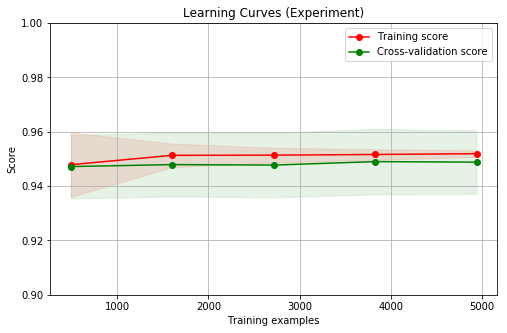

In [465]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
plot_learning_curve(grid_search_pipe.best_estimator_, 
                    "Learning Curves (Experiment)", 
                    new_features, labels, ylim=(0.9, 1.), cv=cv, n_jobs=4)
plt.show()

# experiment_estimator = grid_search_pipe.best_estimator_
# roc = plot_roc_curve(experiment_estimator, new_features_test, labels_test, title="Experiment")
# roc.show()

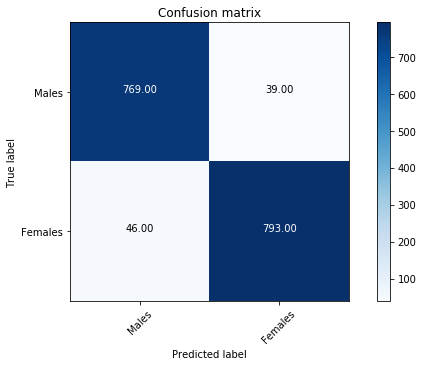

In [466]:
cnf_matrix = confusion_matrix(labels_test, grid_search_pipe.best_estimator_.predict(new_features_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix', normalize=True)
plt.show()

### Best model selection

In [118]:
# Prints the models ordered by the mean test score
logistic_regression_score = grid_search_logistic_regresion.best_estimator_.score(features_test, labels_test)
linear_svm_score = grid_search_linear_svm.best_estimator_.score(features_test, labels_test)
gaussin_svm_score = grid_search_svm.best_estimator_.score(features_test, labels_test)
random_forest_score = grid_search_forest.best_estimator_.score(features_test, labels_test)
ada_boost_score = ada_boost_grid_search.best_estimator_.score(features_test, labels_test)

res = pd.DataFrame({'Classificator': ["Logistic Regressin", "Linear SVM", "Gaussian SVM", 
                                "Random Forest", "AdaBoost with Decision tree"], 
                   'Mean test score': [logistic_regression_score, linear_svm_score, gaussin_svm_score, 
                                       random_forest_score, ada_boost_score]})

res.sort_values(by='Mean test score', inplace=True, ascending=False)
res.head()

,Classificator,Mean test score
2,Gaussian SVM,0.876138
1,Linear SVM,0.844566
0,Logistic Regressin,0.839101
4,AdaBoost with Decision tree,0.810565
3,Random Forest,0.772313


- **Logistic regression, Linear SVM, Random Forest and AdaBoost**: From the graph of Logistic Regression and Linear SVM, it can be seen that it is difficult to achieve better results even if additional training samples are added. Refinement of parameters also does not work well. Тherefore a larger bias need to be applied. Maybe adding of polynomial features to the Logistic Regression model may work but in this case the features are too many for polynomial regression.


- On the other hand, the **Gaussian SVM** model gives the best results and, despite the variation, it seems that adding more samples will decrease it and will increase the test accuracy.

На базата на направените k-Fold cross validatin and grid search за най-добрите параметри можем да извадим следното сравнение. От таблицата се вижда, че най-добри резултати е дал SVM with Gaussina kernel. Въпреки, че не е съвсем перфектен и има лека вариция с по-голям брой тренировъчни семпли и по-подробен Grid search биха могли да бъдат постигнати още по-добри резултати т.е. падане на вариацията и качване на test score.

## Demo

### Define an util functions

In [36]:
FACE_CASCADE_PATH = './faces_data/face.xml'

def predict(image):
    """ 
    Display the result of several models 
    If a model does not exists - try to load a saved model from the local storage
    If a model exists but is not saved - save a model to a local sotrage
    If a model is already saved - use the model from the memory (do not use the saved model)
    """
    svm_model = None
    logistic_regression_model = None
    ada_boost_model = None
    
    row_image = image.ravel()
    
    names = [('grid_search_svm', './svm_model.sav', 'Gaussian SVM model'),
             ('grid_search_logistic_regresion', './logistic_regression_model.sav', 'Logistic Regression model'),
             ('ada_boost_grid_search', './ada_boost_model.sav', 'AdaBoost model')] 
    # ('grid_search_pipe', './pipe.sav', 'New model'
    res = ""
    for tuple_name in names:
        model_name = tuple_name[0]
        location = tuple_name[1]
        title = tuple_name[2]
        
        try:
            if not os.path.exists(location) and model_name in globals():
                model = (globals()[model_name]).best_estimator_
                pickle.dump(model, open(location, 'wb'))
                print("A model is dumped.")
            elif os.path.exists(location) and not model_name in globals():
                model = pickle.load(open(location, 'rb'))
                print("Warn: A model is loaded from the local storage.")
            elif model_name in globals():
                model = (globals()[model_name]).best_estimator_
                print("A model is used from the memory.")
            else:
                print("Error: the program can't find a model not in memory or the local storage. " + 
                      "Please build a model first.")

            res += get_result(model.predict_proba([row_image]), title) + "\n\n"
    
            ##### Experiment START #####
        #     svm = grid_search_svm.predict_proba([row_image])[0][1]
        #     lr = grid_search_logistic_regresion.predict_proba([row_image])[0][1]
        #     ada = ada_boost_grid_search.predict_proba([row_image])[0][1]

        #     experiment = grid_search_pipe.predict_proba([[svm, lr, ada]])
        #     res += get_result(experiment, "Experiment") + "\n\n"
            ##### Experiment END ##### 
        except Exception as ex:
            if ada_boost_model is None:
                print("Unable to load AdaBoos model from the local storage. Please, build the model first.")
            print(ex)
            
    plt.figure()
    plt.imshow(image.reshape(40,40), cmap=plt.cm.bone)
    plt.annotate(res,xy=(0,0), xytext=(45,20), fontsize=20)    

    
def get_result(result_proba, title):
    """ Returns a result with model title """
    if result_proba[0][1] > .5:
        res = "Man({:.2f}%)".format(result_proba[0][1]*100.)
    else:
        res ="Woman({:.2f}%)".format(result_proba[0][0]*100.)
        
    return "{}: {}".format(title, res)

### Recognize faces from camera

Warn: A model is loaded from the local storage.
Warn: A model is loaded from the local storage.
A model is used from the memory.


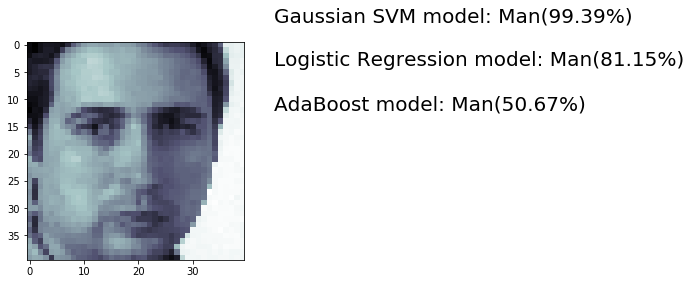

In [33]:
def recognize_faces_from_frame():
    # data:       https://github.com/opencv/opencv/tree/master/data/haarcascades
    # faces, see: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    my_image = None

    size = 50

    cap = cv2.VideoCapture(0)
    is_running = True
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # looks for faces within the image
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        w = 0 #30
        h = 0 #50
        for (x, y, width, height) in faces:
            # draws a rectangle around the detected face
            cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
            face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]

            if cv2.waitKey(1) == ord('q') or not is_running:
                resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
                try:
                    predict(resized)
                except Exception as ex:
                    print("Error: {}".format(ex))           
                is_running = False

        cv2.imshow('frame', frame)

        if not is_running:
            break

    cap.release()
    cv2.destroyAllWindows()

extract_faces_from_frame()

### Recognize faces from image

In [37]:
def recognize_faces_from_image(image):
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    w = 0
    h = 0
    for (x, y, width, height) in faces:
        cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
        face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        try:
            predict(resized)
        except Exception as ex:
            print("Error: {}".format(ex))

recognize_faces_from_image('')        

TypeError: src is not a numpy array, neither a scalar